# Visualizing embeddings


In [1]:
import datasets
from transformers import AutoTokenizer, AutoModelForSequenceClassification, \
    AutoModelForQuestionAnswering, Trainer, TrainingArguments, HfArgumentParser, pipeline
from helpers import prepare_dataset_nli, prepare_train_dataset_qa, \
    prepare_validation_dataset_qa, QuestionAnsweringTrainer, compute_accuracy
import os
import json

NUM_PREPROCESSING_WORKERS = 2

In [2]:
from sklearn.decomposition import PCA
import torch
import matplotlib.pyplot as plt

In [3]:
def get_tensor(word):
    return torch.tensor(tokenizer(word)['input_ids'][1])

In [4]:
def get_embedding(word):
    tensor = get_tensor(word)
    return embeddings(tensor).detach()

In [5]:
def get_embedding_matrix(words):
    res = []
    for word in words:
        res.append(get_embedding(word))
    return torch.stack(res).numpy()

In [8]:
temp_words = ['hot', 'warm', 'cool', 'cold']

In [26]:
intelligence_words = ['intelligent', 'smart', 'clever', 'dumb', 'stupid', 'idiotic']

In [39]:
other_words = ['arbitrary', 'random', 'friendly', 'angry', 'goat', 'australia', 'billion', 'hunger', 'asbestos']

In [40]:
words = temp_words+other_words+intelligence_words

# model - antoynm-negation2

In [61]:
# model pipeline (includes tokenization)
mp = pipeline("question-answering", model='experiments/antonym-negation2/model/', )

In [62]:
tokenizer = mp.tokenizer
model = mp.model
embeddings = model.get_input_embeddings()

In [63]:
X = get_embedding_matrix(words)
pca = PCA(n_components=2)
pca.fit(X)

PCA(n_components=2)

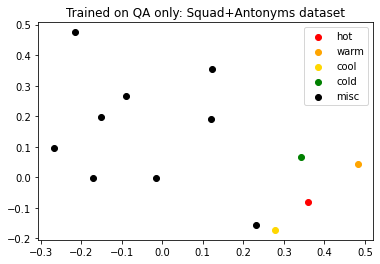

In [64]:
temp_colors = ['red', 'orange', 'gold', 'green']
for i, word in enumerate(temp_words):
    t = pca.transform(get_embedding_matrix([word]))
    plt.scatter(t[:,0], t[:,1], c=temp_colors[i], label=word)
others = pca.transform(get_embedding_matrix(other_words))
plt.scatter(others[:,0], others[:,1], c='k', label='misc')
plt.title('Trained on QA only: Squad+Antonyms dataset')
plt.legend()

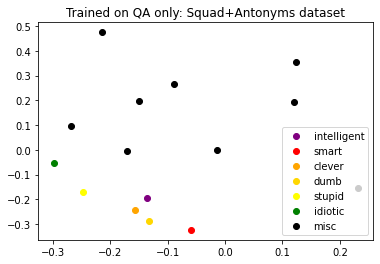

In [65]:
colors = ['purple', 'red', 'orange', 'gold', 'yellow', 'green']
for i, word in enumerate(intelligence_words):
    t = pca.transform(get_embedding_matrix([word]))
    plt.scatter(t[:,0], t[:,1], c=colors[i], label=word)
others = pca.transform(get_embedding_matrix(other_words))
plt.scatter(others[:,0], others[:,1], c='k', label='misc')
plt.title('Trained on QA only: Squad+Antonyms dataset')
plt.legend()

In [66]:
torch.norm(get_embedding('smart') - get_embedding('dumb'))

tensor(0.6243)

In [67]:
torch.norm(get_embedding('intelligent') - get_embedding('stupid'))

tensor(0.7283)

In [68]:
torch.norm(get_embedding('smart') - get_embedding('intelligent'))

tensor(0.5478)

In [69]:
torch.norm(get_embedding('dumb') - get_embedding('stupid'))

tensor(0.5281)

# model - trained on mlm antonyms

In [46]:
# model pipeline (includes tokenization)
mp = pipeline("question-answering", model='experiments/mlm_both_plus_qa_both/model/', )

In [47]:
tokenizer = mp.tokenizer
model = mp.model
embeddings = model.get_input_embeddings()

In [48]:
X = get_embedding_matrix(words)
pca = PCA(n_components=2)
pca.fit(X)

PCA(n_components=2)

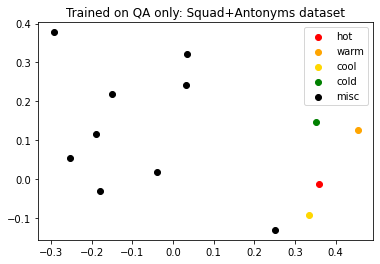

In [49]:
temp_colors = ['red', 'orange', 'gold', 'green']
for i, word in enumerate(temp_words):
    t = pca.transform(get_embedding_matrix([word]))
    plt.scatter(t[:,0], t[:,1], c=temp_colors[i], label=word)
others = pca.transform(get_embedding_matrix(other_words))
plt.scatter(others[:,0], others[:,1], c='k', label='misc')
plt.title('Trained on QA only: Squad+Antonyms dataset')
plt.legend()

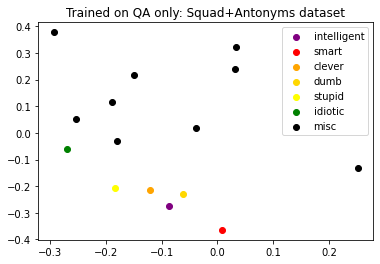

In [50]:
colors = ['purple', 'red', 'orange', 'gold', 'yellow', 'green']
for i, word in enumerate(intelligence_words):
    t = pca.transform(get_embedding_matrix([word]))
    plt.scatter(t[:,0], t[:,1], c=colors[i], label=word)
others = pca.transform(get_embedding_matrix(other_words))
plt.scatter(others[:,0], others[:,1], c='k', label='misc')
plt.title('Trained on QA only: Squad+Antonyms dataset')
plt.legend()

In [57]:
torch.norm(get_embedding('smart') - get_embedding('dumb'))

tensor(0.6017)

In [60]:
torch.norm(get_embedding('intelligent') - get_embedding('stupid'))

tensor(0.7028)

In [58]:
torch.norm(get_embedding('smart') - get_embedding('intelligent'))

tensor(0.5325)

In [59]:
torch.norm(get_embedding('dumb') - get_embedding('stupid'))

tensor(0.5457)